# NASA dataset

In [1]:
!git clone https://github.com/Roshr2211/Predicting-RUL-for-EV-Battery.git


Cloning into 'Predicting-RUL-for-EV-Battery'...
remote: Enumerating objects: 87, done.
remote: Total 87 (delta 0), reused 0 (delta 0), pack-reused 87
Receiving objects: 100% (87/87), 163.78 MiB | 24.36 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Updating files: 100% (36/36), done.


# Importing Packages

In [2]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
def to_padded_numpy(l, shape):
    padded_array = np.zeros(shape)
    padded_array[:len(l)] = l
    return padded_array


In [4]:
def calculate_soc(current, time, initial_capacity):
    # Simple coulomb counting method
    charge = np.trapz(current, time)
    soc = 1 - (charge / initial_capacity)
    return np.clip(soc, 0, 1)  # Ensure SOC is between 0 and 1

def calculate_soh(current_capacity, initial_capacity):
    return current_capacity / initial_capacity



In [5]:
def preprocess_data_to_cycles():
    path = "/content/Predicting-RUL-for-EV-Battery/"
    files = [f for f in os.listdir(path) if f.endswith('.mat')]
    dis_mat = [os.path.join(path, f) for f in files]
    battery_grp = {}

    for f in files:
        key = f.split('.')[0]
        battery_grp[key] = key

    bs = [f.split('.')[0] for f in files]

    ds = []
    for f in dis_mat:
        ds.append(loadmat(f))

    types = []
    times = []
    ambient_temperatures = []
    datas = []

    for i in range(len(ds)):
        x = ds[i][bs[i]]["cycle"][0][0][0]
        ambient_temperatures.append(list(map(lambda y: y[0][0], x['ambient_temperature'])))
        types.append(x['type'])
        times.append(x['time'])
        datas.append(x['data'])

    batteries = []
    cycles = []
    for i in range(len(ds)):
        batteries.append(bs[i])
        cycles.append(datas[i].size)

    battery_cycle_df = pd.DataFrame({'Battery': batteries, 'Cycle': cycles}).sort_values('Battery', ascending=True)
    battery_cycle_df.drop_duplicates(inplace=True)

    Cycles = {}
    params = ['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Current_load', 'Voltage_load', 'Time', 'Capacity']

    for i in range(len(bs)):
        Cycles[bs[i]] = {'count': 0}
        for param in params:
            Cycles[bs[i]][param] = [datas[i][j][param][0][0][0] for j in range(datas[i].size) if types[i][j] == 'discharge']

        cap, amb_temp, dis = [], [], []  # Added dis list
        charge_cycles, discharge_cycles, impedance_cycles = 0, 0, 0  # Renamed no_of_cycles to discharge_cycles

        for j in range(datas[i].size):
            if types[i][j] == 'charge':
                charge_cycles += 1
            elif types[i][j] == 'discharge':
                discharge_cycles += 1
                dis.append(discharge_cycles)  # Append the current discharge cycle count
                cap.append(datas[i][j]['Capacity'][0][0][0])
                amb_temp.append(ambient_temperatures[i][j])
            elif types[i][j] == 'impedance':
                impedance_cycles += 1

        Cycles[bs[i]]['Capacity'] = np.array(cap)
        Cycles[bs[i]]['ambient_temperatures'] = np.array(amb_temp)
        Cycles[bs[i]]['discharge_count'] = np.array(dis)  # Add the discharge cycle numbers

        initial_capacity = Cycles[bs[i]]['Capacity'][0]
        Cycles[bs[i]].update({
            'SOC': [],
            'SOH': [],
            'Cycle_count': [],
            'charge_count': [],
            'impedance_count': []
        })

        for j in range(len(Cycles[bs[i]]['Capacity'])):
            current = np.array(Cycles[bs[i]]['Current_measured'][j])
            time = np.array(Cycles[bs[i]]['Time'][j])
            capacity = Cycles[bs[i]]['Capacity'][j]

            soc = calculate_soc(current, time, initial_capacity)
            soh = calculate_soh(capacity, initial_capacity)

            Cycles[bs[i]]['SOC'].append(soc)
            Cycles[bs[i]]['SOH'].append(soh)
            # Cycles[bs[i]]['discharge_count'].append(discharge_cycles)  # Use discharge_cycles instead of no_of_cycles
            Cycles[bs[i]]['charge_count'].append(charge_cycles)
            Cycles[bs[i]]['impedance_count'].append(impedance_cycles)
            total_cycles = charge_cycles + discharge_cycles + impedance_cycles
            Cycles[bs[i]]['Cycle_count'].append(total_cycles)

    Cycles = pd.DataFrame(Cycles)

    return Cycles

In [39]:
def preprocess_data_to_cycles():
    # ... [previous code remains the same] ...

    for i in range(len(bs)):
        Cycles[bs[i]] = {'count': 0}
        for param in params:
            Cycles[bs[i]][param] = [datas[i][j][param][0][0][0] for j in range(datas[i].size) if types[i][j] == 'discharge']

        cap, amb_temp, dis = [], [], []  # Added dis list
        charge_cycles, discharge_cycles, impedance_cycles = 0, 0, 0  # Renamed no_of_cycles to discharge_cycles

        for j in range(datas[i].size):
            if types[i][j] == 'charge':
                charge_cycles += 1
            elif types[i][j] == 'discharge':
                discharge_cycles += 1
                dis.append(discharge_cycles)  # Append the current discharge cycle count
                cap.append(datas[i][j]['Capacity'][0][0][0])
                amb_temp.append(ambient_temperatures[i][j])
            elif types[i][j] == 'impedance':
                impedance_cycles += 1

        Cycles[bs[i]]['Capacity'] = np.array(cap)
        Cycles[bs[i]]['ambient_temperatures'] = np.array(amb_temp)
        Cycles[bs[i]]['discharge_number'] = np.array(dis)  # Add the discharge cycle numbers

        initial_capacity = Cycles[bs[i]]['Capacity'][0]
        Cycles[bs[i]].update({
            'discharge_count': [],
            'SOC': [],
            'SOH': [],
            'Cycle_count': [],
            'charge_count': [],
            'impedance_count': []
        })

        for j in range(len(Cycles[bs[i]]['Capacity'])):
            current = np.array(Cycles[bs[i]]['Current_measured'][j])
            time = np.array(Cycles[bs[i]]['Time'][j])
            capacity = Cycles[bs[i]]['Capacity'][j]

            soc = calculate_soc(current, time, initial_capacity)
            soh = calculate_soh(capacity, initial_capacity)

            Cycles[bs[i]]['SOC'].append(soc)
            Cycles[bs[i]]['SOH'].append(soh)
            Cycles[bs[i]]['discharge_count'].append(discharge_cycles)  # Use discharge_cycles instead of no_of_cycles
            Cycles[bs[i]]['charge_count'].append(charge_cycles)
            Cycles[bs[i]]['impedance_count'].append(impedance_cycles)
            total_cycles = charge_cycles + discharge_cycles + impedance_cycles
            Cycles[bs[i]]['Cycle_count'].append(total_cycles)

    Cycles = pd.DataFrame(Cycles)

    return Cycles

In [37]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat

def calculate_soc(current, time, initial_capacity):
    # Placeholder function to calculate SOC
    return (initial_capacity - np.sum(current * time)) / initial_capacity

def calculate_soh(current_capacity, initial_capacity):
    # Placeholder function to calculate SOH
    return current_capacity / initial_capacity

def preprocess_data_to_cycles():
    path = "/content/Predicting-RUL-for-EV-Battery/"
    files = [f for f in os.listdir(path) if f.endswith('.mat')]
    dis_mat = [os.path.join(path, f) for f in files]
    battery_grp = {f.split('.')[0]: f.split('.')[0] for f in files}
    bs = list(battery_grp.keys())

    ds = [loadmat(f) for f in dis_mat]

    types, times, ambient_temperatures, datas = [], [], [], []

    for i in range(len(ds)):
        x = ds[i][bs[i]]["cycle"][0][0][0]
        ambient_temperatures.append([y[0][0] for y in x['ambient_temperature']])
        types.append(x['type'])
        times.append(x['time'])
        datas.append(x['data'])

    batteries = [bs[i] for i in range(len(ds))]
    cycles = [datas[i].size for i in range(len(ds))]

    battery_cycle_df = pd.DataFrame({'Battery': batteries, 'Cycle': cycles}).sort_values('Battery').drop_duplicates()

    Cycles = {}
    params = ['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Current_load', 'Voltage_load', 'Time', 'Capacity']

    for i in range(len(bs)):
        Cycles[bs[i]] = {'count': 0}
        for param in params:
            Cycles[bs[i]][param] = [datas[i][j][param][0][0][0] for j in range(datas[i].size) if types[i][j] == 'discharge']

        cap, amb_temp = [], []
        charge_cycles, no_of_cycles, impedance_cycles = 0, 0, 0

        for j in range(datas[i].size):
            if types[i][j] == 'charge':
                charge_cycles += 1
            elif types[i][j] == 'discharge':
                no_of_cycles += 1
                cap.append(datas[i][j]['Capacity'][0][0][0])
                amb_temp.append(ambient_temperatures[i][j])
            elif types[i][j] == 'impedance':
                impedance_cycles += 1

        Cycles[bs[i]]['Capacity'] = np.array(cap)
        Cycles[bs[i]]['ambient_temperatures'] = np.array(amb_temp)

        initial_capacity = Cycles[bs[i]]['Capacity'][0]
        Cycles[bs[i]].update({
            'discharge_count': [],
            'SOC': [],
            'SOH': [],
            'Cycle_count': [],
            'charge_count': [],
            'impedance_count': []
        })

        for j in range(len(Cycles[bs[i]]['Capacity'])):
            current = np.array(Cycles[bs[i]]['Current_measured'][j])
            time = np.array(Cycles[bs[i]]['Time'][j])
            capacity = Cycles[bs[i]]['Capacity'][j]

            soc = calculate_soc(current, time, initial_capacity)
            soh = calculate_soh(capacity, initial_capacity)

            Cycles[bs[i]]['SOC'].append(soc)
            Cycles[bs[i]]['SOH'].append(soh)
            Cycles[bs[i]]['discharge_count'].append(no_of_cycles)
            Cycles[bs[i]]['charge_count'].append(charge_cycles)
            Cycles[bs[i]]['impedance_count'].append(impedance_cycles)
            total_cycles = charge_cycles + no_of_cycles + impedance_cycles
            Cycles[bs[i]]['Cycle_count'].append(total_cycles)

    Cycles = pd.DataFrame(Cycles)

    return Cycles


In [27]:
def preprocess_data_to_cycles():
    path = "/content/Predicting-RUL-for-EV-Battery/"
    files = [f for f in os.listdir(path) if f.endswith('.mat')]
    dis_mat = [os.path.join(path, f) for f in files]
    battery_grp = {f.split('.')[0]: f.split('.')[0] for f in files}
    bs = list(battery_grp.keys())

    ds = [loadmat(f) for f in dis_mat]

    types, times, ambient_temperatures, datas = [], [], [], []

    for i in range(len(ds)):
        x = ds[i][bs[i]]["cycle"][0][0][0]
        ambient_temperatures.append([y[0][0] for y in x['ambient_temperature']])
        types.append(x['type'])
        times.append(x['time'])
        datas.append(x['data'])

    batteries = [bs[i] for i in range(len(ds))]
    cycles = [datas[i].size for i in range(len(ds))]

    battery_cycle_df = pd.DataFrame({'Battery': batteries, 'Cycle': cycles}).sort_values('Battery').drop_duplicates()

    Cycles = {}
    params = ['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Current_load', 'Voltage_load', 'Time', 'Capacity']

    for i in range(len(bs)):
        Cycles[bs[i]] = {'count': 0, 'discharge_count': [], 'SOC': [], 'SOH': [], 'Cycle_count': [], 'charge_count': [], 'impedance_count': []}
        for param in params:
            Cycles[bs[i]][param] = [datas[i][j][param][0][0][0] for j in range(datas[i].size) if types[i][j] == 'discharge']

        cap, amb_temp = [], []
        charge_cycles, no_of_cycles, impedance_cycles = 0, 0, 0

        for j in range(datas[i].size):
            if types[i][j] == 'charge':
                charge_cycles += 1
            elif types[i][j] == 'discharge':
                no_of_cycles += 1
                Cycles[bs[i]]['discharge_count'].append(no_of_cycles)
                cap.append(datas[i][j]['Capacity'][0][0][0])
                amb_temp.append(ambient_temperatures[i][j])
            elif types[i][j] == 'impedance':
                impedance_cycles += 1

        Cycles[bs[i]]['Capacity'] = np.array(cap)
        Cycles[bs[i]]['ambient_temperatures'] = np.array(amb_temp)

        initial_capacity = Cycles[bs[i]]['Capacity'][0]

        for j in range(len(Cycles[bs[i]]['Capacity'])):
            current = np.array(Cycles[bs[i]]['Current_measured'][j])
            time = np.array(Cycles[bs[i]]['Time'][j])
            capacity = Cycles[bs[i]]['Capacity'][j]

            soc = calculate_soc(current, time, initial_capacity)
            soh = calculate_soh(capacity, initial_capacity)

            Cycles[bs[i]]['SOC'].append(soc)
            Cycles[bs[i]]['SOH'].append(soh)

            Cycles[bs[i]]['charge_count'].append(charge_cycles)
            Cycles[bs[i]]['impedance_count'].append(impedance_cycles)
            total_cycles = charge_cycles + no_of_cycles + impedance_cycles
            Cycles[bs[i]]['Cycle_count'].append(total_cycles)

    Cycles = pd.DataFrame(Cycles).transpose()
    return Cycles


In [35]:
# def preprocess_data_to_cycles():
#     path = "/content/Predicting-RUL-for-EV-Battery/"
#     files = [f for f in os.listdir(path) if f.endswith('.mat')]
#     dis_mat = [os.path.join(path, f) for f in files]
#     battery_grp = {f.split('.')[0]: f.split('.')[0] for f in files}
#     bs = list(battery_grp.keys())

#     ds = [loadmat(f) for f in dis_mat]

#     types, times, ambient_temperatures, datas = [], [], [], []

#     for i in range(len(ds)):
#         x = ds[i][bs[i]]["cycle"][0][0][0]
#         ambient_temperatures.append([y[0][0] for y in x['ambient_temperature']])
#         types.append(x['type'])
#         times.append(x['time'])
#         datas.append(x['data'])

#     batteries = [bs[i] for i in range(len(ds))]
#     cycles = [datas[i].size for i in range(len(ds))]

#     battery_cycle_df = pd.DataFrame({'Battery': batteries, 'Cycle': cycles}).sort_values('Battery').drop_duplicates()

#     params = ['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Current_load', 'Voltage_load', 'Time', 'Capacity']

#     Cycles = {param: {} for param in params}
#     Cycles.update({'discharge_count': {}, 'SOC': {}, 'SOH': {}, 'Cycle_count': {}, 'charge_count': {}, 'impedance_count': {}})

#     for i in range(len(bs)):
#         for param in params:
#             Cycles[param][bs[i]] = [datas[i][j][param][0][0][0] for j in range(datas[i].size) if types[i][j] == 'discharge']

#         cap, amb_temp = [], []
#         charge_cycles, no_of_cycles, impedance_cycles = 0, 0, 0

#         for j in range(datas[i].size):
#             if types[i][j] == 'charge':
#                 charge_cycles += 1
#             elif types[i][j] == 'discharge':
#                 no_of_cycles += 1
#                 cap.append(datas[i][j]['Capacity'][0][0][0])
#                 amb_temp.append(ambient_temperatures[i][j])
#             elif types[i][j] == 'impedance':
#                 impedance_cycles += 1

#         initial_capacity = cap[0]

#         Cycles['Capacity'][bs[i]] = cap
#         Cycles['ambient_temperatures'][bs[i]] = amb_temp
#         Cycles['discharge_count'][bs[i]] = [no_of_cycles] * len(cap)
#         Cycles['charge_count'][bs[i]] = [charge_cycles] * len(cap)
#         Cycles['impedance_count'][bs[i]] = [impedance_cycles] * len(cap)
#         Cycles['SOC'][bs[i]] = [calculate_soc(np.array(Cycles['Current_measured'][bs[i]][j]), np.array(Cycles['Time'][bs[i]][j]), initial_capacity) for j in range(len(cap))]
#         Cycles['SOH'][bs[i]] = [calculate_soh(capacity, initial_capacity) for capacity in cap]
#         Cycles['Cycle_count'][bs[i]] = [charge_cycles + no_of_cycles + impedance_cycles] * len(cap)

#     Cycles_df = pd.DataFrame(Cycles)

#     return Cycles_df



In [6]:
Cycles = preprocess_data_to_cycles()
Cycles.head()

,B0007,B0031,B0025,B0053,B0049,B0040,B0018,B0030,B0041,B0055,...,B0029,B0047,B0033,B0046,B0048,B0036,B0054,B0027,B0045,B0006
count,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Voltage_measured,"[[4.199359521791473, 4.199497433806136, 3.9856...","[[4.116561748956975, 4.1165602762786495, 3.786...","[[4.196831409847343, 4.196965327364252, 3.7284...","[[4.081952934128504, 4.082016063841389, 3.6783...","[[3.8454913513399713, 3.8462292855248927, 3.48...","[[4.068028641979544, 4.06792899844375, 3.40456...","[[4.188108651124536, 4.188195942647034, 3.9774...","[[4.121227217169418, 4.121228264511843, 3.7858...","[[4.18669249732225, 4.18729715087111, 3.368703...","[[3.843735024444539, 3.8434968828378473, 3.335...",...,"[[4.122635846291491, 4.122758586822445, 3.8045...","[[4.246711253516259, 4.246764125510136, 4.0392...","[[3.6772190710694983, 3.6769169159399326, 2.91...","[[4.237702541731068, 4.23781853684158, 4.03629...","[[4.223690952621402, 4.223668892674369, 4.0055...","[[3.848136609578083, 3.847910503992072, 3.5309...","[[3.849349497973326, 3.849482783980402, 3.3231...","[[4.201942981365258, 4.20169558339226, 3.63107...","[[4.202937200343293, 4.203467627142882, 3.9573...","[[4.179799607333447, 4.179823027658306, 3.9665..."
Current_measured,"[[-0.0018658918833680202, -0.00213942698980712...","[[-5.512929124633905e-05, 0.001599429927877446...","[[0.0002960063370787373, -0.000388997948814188...","[[-0.0024914557337994726, -0.00265064776634610...","[[-0.0008711091496250029, -0.00095301892474506...","[[-0.007278407684777723, -0.000387355085684015...","[[0.00013066734156636677, 0.001459080605681204...","[[0.00024592298559311063, 0.001759300538562487...","[[-0.0021091286456950743, -0.00072421205649633...","[[0.0012070791085765638, -0.001266519237744346...",...,"[[-0.0006074349136117565, -0.00032066021316996...","[[0.0002523886105860831, -0.001411064736238816...","[[-0.0017413885759315839, -0.00164386763932524...","[[-0.0033574658677139302, -0.00213493095206640...","[[0.0007856158063428508, -0.000108344110450785...","[[-0.0021557335495844556, -0.00333923074910676...","[[0.0007080966847512267, -0.002099358546635165...","[[-0.0017169064250815253, 0.000477976788551639...","[[-0.0018552703653270512, -0.00199247895776828...","[[-0.0023663271409738672, 0.000433762465751178..."
Temperature_measured,"[[23.93704394613529, 23.92407356409745, 24.004...","[[42.830036312976034, 42.83746343556693, 42.88...","[[26.51514107879548, 26.503791065076168, 26.58...","[[5.6480393241342135, 5.655563478290417, 5.714...","[[9.292640050962104, 9.298540811354455, 9.2761...","[[24.62082872256712, 24.727002320884992, 24.89...","[[23.8195202516044, 23.82880715958107, 23.8449...","[[43.15149833518289, 43.152385790022294, 43.17...","[[4.842367203458604, 4.851633920548016, 5.0830...","[[5.905007114660983, 5.921671343364951, 5.9849...",...,"[[43.41517780938604, 43.40626577176862, 43.443...","[[6.212696115916043, 6.234018870000787, 6.2502...","[[23.712130442495322, 23.709046954662966, 23.8...","[[6.398455346375354, 6.417595235420346, 6.4320...","[[6.52486744360099, 6.535332076827696, 6.56690...","[[23.91297719702689, 23.924528458759017, 23.92...","[[6.150630538748289, 6.174259621680745, 6.2219...","[[26.288547313515906, 26.281751283369985, 26.4...","[[6.546128313360122, 6.566538966413903, 6.6052...","[[24.277567510331888, 24.27707330832413, 24.36..."
Current_load,"[[-0.0004, -0.0004, -2.0, -2.0, -2.0, -2.0, -2...","[[0.0006, 0.0004, 3.997, 3.997, 3.997, 3.997, ...","[[0.0004, 0.0004, 3.996, 0.0004, 3.996, 0.0004...","[[0.0004, 0.0004, 1.9976, 1.9976, 1.9976, 1.99...","[[0.0, 0.0, 1.9972, 1.9972, 1.9972, 1.9972, 1....","[[0.0002, 0.0, 4.001, 4.0, 4.001, 4.0, 4.001, ...","[[0.0006, 0.0006, 1.9988, 1.9988, 1.9988, 1.99...","[[0.0006, 0.0006, 4.001, 4.001, 4.001, 4.001, ...","[[0.0006, 0.0006, 3.996, 3.996, 3.996, 3.996, ...","[[0.0004, 0.0002, 1.9992, 1.9992, 1.999, 1.999...",...,"[[0.0004, 0.0006, 3.995, 3.995, 3.995, 3.995, ...","[[0.0002, 0.0002, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0..

In [7]:
  Cycles = preprocess_data_to_cycles()
  df_all = pd.DataFrame({})
  max_len = 0

  exp_try_out = ['B0005']

  for bat in exp_try_out:
      if bat not in Cycles.columns:
          print(f"Battery {bat} not found in Cycles DataFrame")
          continue

      df = pd.DataFrame({})
      cols = ['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Current_load', 'Voltage_load', 'Time', 'Capacity', 'ambient_temperatures', 'SOC', 'SOH', 'Cycle_count','discharge_count']
      for col in cols:
          df[col] = Cycles[bat][col]
      max_l = np.max(df['Time'].apply(lambda x: len(x)).values)
      max_len = max(max_l, max_len)
      df_all = pd.concat([df_all, df], ignore_index=True)

  df = df_all.reset_index(drop=True)

  for i, j in enumerate(df['Capacity']):
      try:
          if len(j):
              df['Capacity'][i] = j[0]
          else:
              df['Capacity'][i] = 0
      except:
          pass
  df_all.head(10)

,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time,Capacity,ambient_temperatures,SOC,SOH,Cycle_count,discharge_count
0,"[4.191491807505295, 4.190749067776103, 3.97487...","[-0.004901589207462691, -0.0014780055516425076...","[24.330033885570543, 24.325993424022467, 24.38...","[-0.0006, -0.0006, -1.9982, -1.9982, -1.9982, ...","[0.0, 4.206, 3.062, 3.03, 3.011, 2.991, 2.977,...","[0.0, 16.781, 35.702999999999996, 53.781, 71.9...",1.856487,24,[1.0],[1.0],616,1
1,"[4.189773213846608, 4.188881380279099, 3.97915...","[2.125117981080765e-05, -0.0008794712663407272...","[24.697751935729325, 24.685948163596, 24.73813...","[-0.0006, -0.0006, -1.9984, -1.9982, -1.9984, ...","[0.0, 4.204, 3.056, 3.024, 3.003, 2.983, 2.973...","[0.0, 16.672, 35.703, 53.828, 71.891, 90.047, ...",1.846327,24,[1.0],[0.9945272071416714],616,2
2,"[4.188186735991303, 4.187198338393574, 3.97999...","[-0.0017540301662326099, -0.001791647748693578...","[24.734266163954402, 24.74050014862512, 24.791...","[-0.0006, -0.0006, -1.9982, -1.9982, -1.9982, ...","[0.0, 4.203, 3.055, 3.023, 3.0, 2.981, 2.97, 2...","[0.0, 16.796999999999997, 35.766, 53.891, 72.0...",1.835349,24,[1.0],[0.9886138595081705],616,3
3,"[4.188461118855572, 4.187752210174129, 3.98161...","[-0.0027750361294468047, 0.0002337127076932362...","[24.65423646922845, 24.652243741292516, 24.697...","[-0.0006, -0.0006, -1.9982, -1.9982, -1.9982, ...","[0.0, 4.203, 3.055, 3.023, 2.999, 2.982, 2.97,...","[0.0, 16.766000000000002, 35.75, 53.813, 72.04...",1.835263,24,[1.0],[0.9885671763794173],616,4
4,"[4.188298524761055, 4.187384730878918, 3.98225...","[-0.007980866803888688, 0.001701454824503414, ...","[24.524796959348127, 24.518700434435164, 24.57...","[-0.0006, -0.0006, -1.9982, -1.9982, -1.9982, ...","[0.0, 4.203, 3.056, 3.025, 3.0, 2.984, 2.973, ...","[0.0, 16.719, 35.656000000000006, 53.859, 72.0...",1.834646,24,[1.0],[0.9882348178817771],616,5
5,"[4.188815807948604, 4.1879392092822485, 3.9834...","[-0.005055568294146982, -0.0009232092459990111...","[24.522297376927863, 24.51442664842638, 24.580...","[-0.0006, -0.0006, -1.9982, -1.9984, -1.9982, ...","[0.0, 4.203, 3.055, 3.024, 2.999, 2.981, 2.969...","[0.0, 16.719, 35.703, 53.906, 71.953, 90.11, 1...",1.835662,24,[1.0],[0.9887821697485943],616,6
6,"[4.18839163793879, 4.187721725257911, 3.984584...","[-0.002633435144531069, -0.0001578889704540309...","[24.58487828579781, 24.575581239008407, 24.638...","[-0.0006, -0.0008, -1.9982, -1.9982, -1.9982, ...","[0.0, 4.203, 3.055, 3.026, 2.999, 2.978, 2.966...","[0.0, 16.719, 35.562, 53.687, 71.8909999999999...",1.835146,24,[1.0],[0.9885044855913476],616,7
7,"[4.188927891511958, 4.188023389493804, 3.98607...","[0.002227616056915605, -0.0012558058624834187,...","[24.713628799279793, 24.71132429046902, 24.769...","[-0.0006, -0.0006, -1.9982, -1.9982, -1.9982, ...","[0.0, 4.203, 3.051, 3.02, 2.996, 2.975, 2.964,...","[0.0, 16.75, 35.578, 53.844, 72.031, 90.109000...",1.825757,24,[1.0],[0.9834468955151549],616,8
8,"[4.189029250882121, 4.187448221825881, 3.98618...","[-0.0021960382833998496, 0.005401028321021492,...","[24.635211633324694, 24.628487294051176, 24.68...","[-0.0006, -0.0006, -1.9982, -1.9982, -1.9982, ...","[0.0, 4.203, 3.052, 3.022, 2.997, 2.979, 2.969...","[0.0, 16.733999999999995, 35.578, 53.719, 71.8...",1.824774,24,[1.0],[0.9829174345738104],616,9
9,"[4.189223427076418, 4.188691924230858, 3.98690...","[-0.005976012336206865, -0.003552717237444042,...","[24.572057664095553, 24.561560340089137, 24.61...","[-0.0006, -0.0008, -1.9982, -1.9982, -1.9982, ...","[0.0, 4.204, 3.06, 3.029, 3.001, 2.985, 2.975,...","[0.0, 16.672000000000004, 35.563, 53.735, 71.7...",1.824613,24,[1.0],[0.982830935473199],616,10


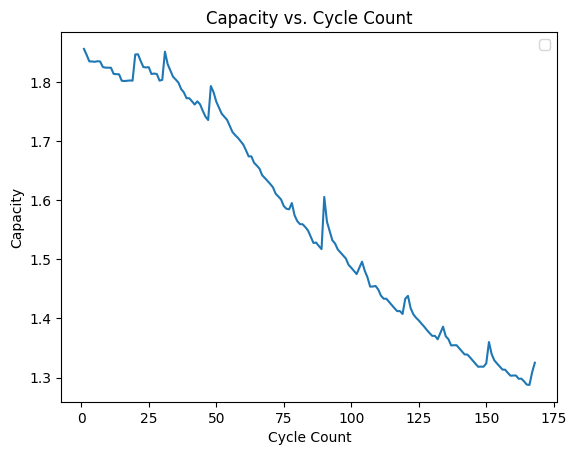

In [8]:
plt.plot(df_all['discharge_count'], df_all['Capacity'])
plt.xlabel('Cycle Count')
plt.ylabel('Capacity')
plt.title('Capacity vs. Cycle Count')
plt.legend()
plt.show()

KeyError: 'Cycle_count'

In [9]:
def get_exp_based_df(exp):
    Cycles = preprocess_data_to_cycles()
    df_all = pd.DataFrame({})
    max_len = 0

    exp_try_out = exp

    for bat in exp_try_out:
        if bat not in Cycles.columns:
            print(f"Battery {bat} not found in Cycles DataFrame")
            continue

        df = pd.DataFrame({})
        cols = ['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Current_load', 'Voltage_load', 'Time', 'Capacity', 'ambient_temperatures', 'SOC', 'SOH', 'Cycle_count']
        for col in cols:
            df[col] = Cycles[bat][col]
        max_l = np.max(df['Time'].apply(lambda x: len(x)).values)
        max_len = max(max_l, max_len)
        df_all = pd.concat([df_all, df], ignore_index=True)

    df = df_all.reset_index(drop=True)

    for i, j in enumerate(df['Capacity']):
        try:
            if len(j):
                df['Capacity'][i] = j[0]
            else:
                df['Capacity'][i] = 0
        except:
            pass

    # Separate the target variable
    df_y = df['Capacity'].values

    # Remove only 'Capacity' from df_x
    df_x = df.drop(columns=['Capacity','ambient_temperatures']).values

    n, m = df_x.shape[0], df_x.shape[1]
    temp2 = np.zeros((n, m, max_len))
    for i in range(n):
        for j in range(m):
            if isinstance(df_x[i][j], (np.ndarray, list)):
                temp2[i][j] = to_padded_numpy(df_x[i][j], max_len)
            else:
                # For single values (SOC, SOH, Cycle_count, ambient_temperatures), repeat the value
                temp2[i][j] = np.full(max_len, df_x[i][j])

    df_x = temp2

    return df_x, df_y

def to_padded_numpy(l, shape):
    padded_array = np.zeros(shape)
    padded_array[:len(l)] = l
    return padded_array

In [10]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)  # Self-attention
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_transformer_model(input_shape, embed_dim, num_heads, ff_dim):
    inputs = layers.Input(shape=input_shape)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = layers.Dense(embed_dim)(inputs)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


Epoch 1/10
7/7 [==============================] - 4s 147ms/step - loss: 3.1092 - val_loss: 0.0522
Epoch 2/10
7/7 [==============================] - 0s 29ms/step - loss: 0.3861 - val_loss: 0.1452
Epoch 3/10
7/7 [==============================] - 0s 36ms/step - loss: 0.2459 - val_loss: 0.0862
Epoch 4/10
7/7 [==============================] - 0s 38ms/step - loss: 0.2307 - val_loss: 0.0692
Epoch 5/10
7/7 [==============================] - 0s 55ms/step - loss: 0.1995 - val_loss: 0.0267
Epoch 6/10
7/7 [==============================] - 0s 26ms/step - loss: 0.1720 - val_loss: 0.0327
Epoch 7/10
7/7 [==============================] - 0s 39ms/step - loss: 0.1417 - val_loss: 0.0334
Epoch 8/10
7/7 [==============================] - 0s 40ms/step - loss: 0.1931 - val_loss: 0.0260
Epoch 9/10
7/7 [==============================] - 0s 40ms/step - loss: 0.1391 - val_loss: 0.0293
Epoch 10/10
7/7 [==============================] - 0s 43ms/step - loss: 0.1307 - val_loss: 0.0164


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


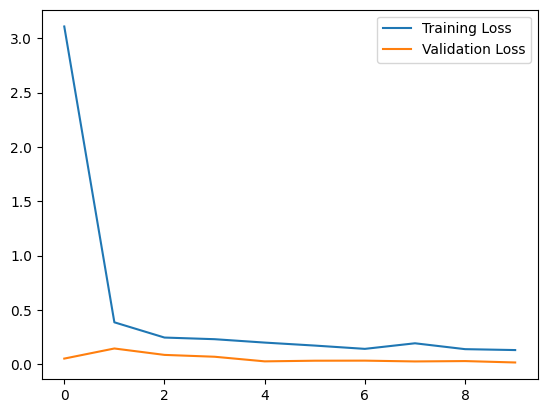

4/4 [==============================] - 0s 5ms/step
       pred      true
0  1.529085  1.563849
1  1.463173  1.501545
2  1.447690  1.456695
3  1.721435  1.879451
4  1.565986  1.728564


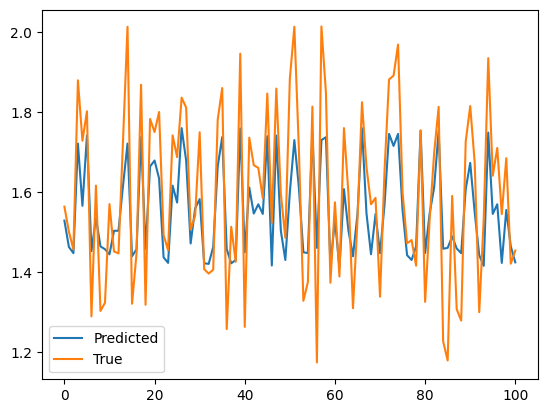

Mean Absolute Error (MAE): 0.10856643239314154
Mean Squared Error (MSE): 0.01643969287910897
Root Mean Squared Error (RMSE): 0.1282173657470351


In [11]:
if __name__ == "__main__":
    experiment1 = ['B0005', 'B0006', 'B0007']
    df_x, df_y = get_exp_based_df(experiment1)
    train_x, test_x, train_y, test_y = train_test_split(df_x, df_y, test_size=0.2, random_state=0)

    # Normalize the data
    scaler = StandardScaler()
    train_x = scaler.fit_transform(train_x.reshape(-1, train_x.shape[-1])).reshape(train_x.shape)
    test_x = scaler.transform(test_x.reshape(-1, test_x.shape[-1])).reshape(test_x.shape)

    # Define the transformer model
    embed_dim = 32  # Embedding size for each token
    num_heads = 2  # Number of attention heads
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer

    model = build_transformer_model(input_shape=train_x.shape[1:], embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')

    LEARNING_RATE = 0.0007
    REGULARIZATION = 0.0002
    EPOCHS = 10
    BATCH_SIZE = 64

    history = model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_x, test_y))

    # Save the trained model
    model.save('rul_prediction_model_transformer.h5')
    loaded_model = keras.models.load_model('rul_prediction_model_transformer.h5', custom_objects={'TransformerBlock': TransformerBlock})

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

    y_pred = model.predict(test_x)

    # Create a DataFrame to compare predictions and true values
    df_pred = pd.DataFrame(data={'pred': y_pred.flatten(), 'true': test_y})
    print(df_pred.head())

    # Plot the predictions and true values
    plt.figure()
    plt.plot(df_pred['pred'], label='Predicted')
    plt.plot(df_pred['true'], label='True')
    plt.legend()
    plt.show()
    new_mae = mean_absolute_error(df_pred['true'], df_pred['pred'])
    new_mse = mean_squared_error(df_pred['true'], df_pred['pred'])
    new_rmse = np.sqrt(new_mse)

    # print(f"Evaluation Metrics for {new_experiment}:")
    print(f"Mean Absolute Error (MAE): {new_mae}")
    print(f"Mean Squared Error (MSE): {new_mse}")
    print(f"Root Mean Squared Error (RMSE): {new_rmse}")

4/4 [==============================] - 0s 5ms/step
       pred      true
0  1.899370  1.847011
1  1.899358  1.848565
2  1.899338  1.847111
3  1.899324  1.848984
4  1.899311  1.837012


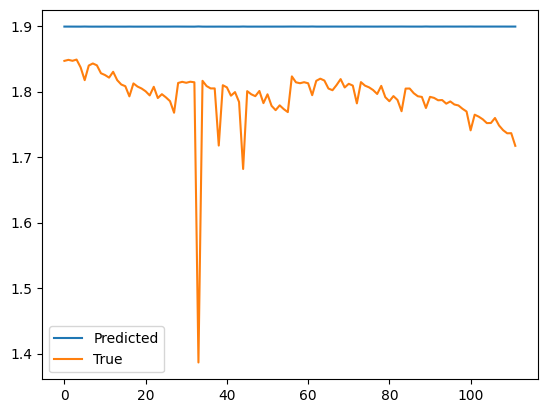

Evaluation Metrics for ['B0025', 'B0026', 'B0027', 'B0028']:
Mean Absolute Error (MAE): 0.10750666079716738
Mean Squared Error (MSE): 0.013844038612132247
Root Mean Squared Error (RMSE): 0.11766069272332305


In [12]:
experiment2 = ["B0025", "B0026", "B0027", "B0028"]
new_experiment = experiment2  # Replace with the new experiment name
new_test_x, new_test_y = get_exp_based_df(new_experiment)

# Normalize the new test data
max_len = train_x.shape[-1]  # Ensure the same length as training data
new_test_x_padded = np.zeros((new_test_x.shape[0], new_test_x.shape[1], max_len))
for i in range(new_test_x.shape[0]):
    for j in range(new_test_x.shape[1]):
        new_test_x_padded[i, j, :new_test_x.shape[2]] = new_test_x[i, j, :max_len]

new_test_x = scaler.transform(new_test_x_padded.reshape(-1, new_test_x_padded.shape[-1])).reshape(new_test_x_padded.shape)

# Make predictions on the new test data
new_y_pred = model.predict(new_test_x)

# Create a DataFrame to compare new predictions and true values
new_df_pred = pd.DataFrame(data={'pred': new_y_pred.flatten(), 'true': new_test_y})
print(new_df_pred.head())

# Plot the new predictions and true values
plt.figure()
plt.plot(new_df_pred['pred'], label='Predicted')
plt.plot(new_df_pred['true'], label='True')
plt.legend()
plt.show()
new_mae = mean_absolute_error(new_df_pred['true'], new_df_pred['pred'])
new_mse = mean_squared_error(new_df_pred['true'], new_df_pred['pred'])
new_rmse = np.sqrt(new_mse)

print(f"Evaluation Metrics for {new_experiment}:")
print(f"Mean Absolute Error (MAE): {new_mae}")
print(f"Mean Squared Error (MSE): {new_mse}")
print(f"Root Mean Squared Error (RMSE): {new_rmse}")

In [13]:
experiment3 = ["B0029", "B0030", "B0031", "B0032"]
experiment4 = ["B0033", "B0034", "B0036"]
experiment5 = ["B0038", "B0039", "B0040"]
experiment6 = ["B0041", "B0042", "B0043", "B0044"]
experiment7 = ["B0045", "B0046", "B0047", "B0048"]
experiment8 = ["B0049", "B0050", "B0051", "B0052"]
experiment9 = ["B0053", "B0054", "B0055", "B0056"]

2/2 [==============================] - 0s 8ms/step
       pred      true
0  1.448390  1.563849
1  1.415758  1.501545
2  1.307475  1.456695
3  1.823413  1.879451
4  1.633996  1.728564


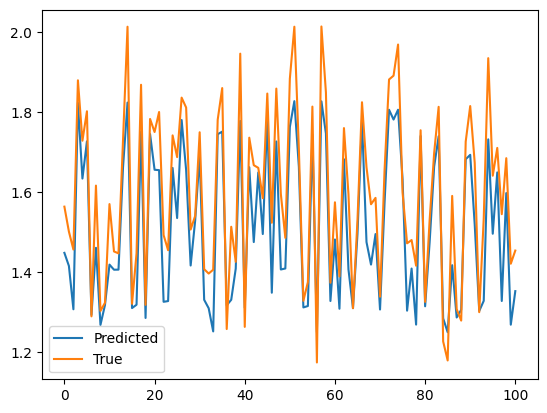

Evaluation Metrics for Test Data:
Mean Absolute Error (MAE): 0.09342614840214751
Mean Squared Error (MSE): 0.01210456724004823
Root Mean Squared Error (RMSE): 0.1100207582233836
       pred      true
0  1.877682  1.847011
1  1.879792  1.848565
2  1.881593  1.847111
3  1.884062  1.848984
4  1.886009  1.837012


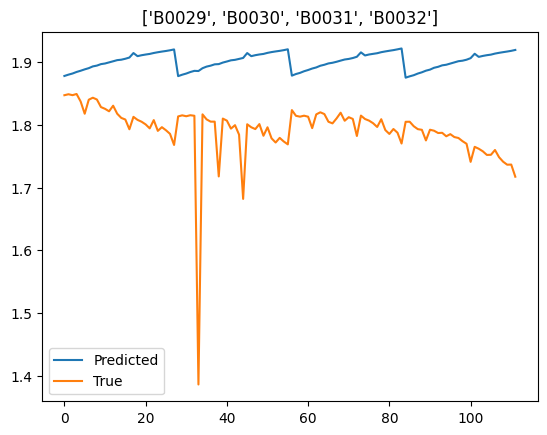

Evaluation Metrics for ['B0029', 'B0030', 'B0031', 'B0032']:
Mean Absolute Error (MAE): 0.10971900426855823
Mean Squared Error (MSE): 0.01474371374782021
Root Mean Squared Error (RMSE): 0.1214236951662245
       pred      true
0  1.877682  1.847011
1  1.879792  1.848565
2  1.881593  1.847111
3  1.884062  1.848984
4  1.886009  1.837012


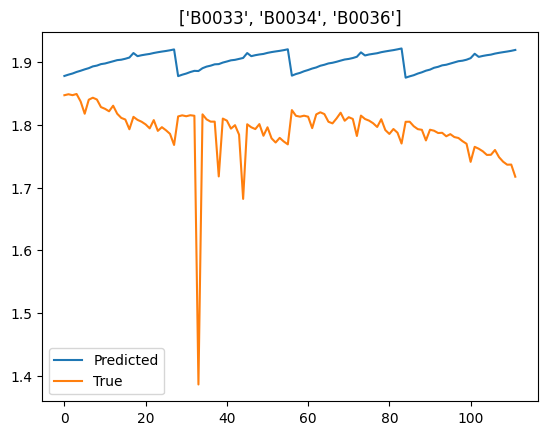

Evaluation Metrics for ['B0033', 'B0034', 'B0036']:
Mean Absolute Error (MAE): 0.10971900426855823
Mean Squared Error (MSE): 0.01474371374782021
Root Mean Squared Error (RMSE): 0.1214236951662245
       pred      true
0  1.877682  1.847011
1  1.879792  1.848565
2  1.881593  1.847111
3  1.884062  1.848984
4  1.886009  1.837012


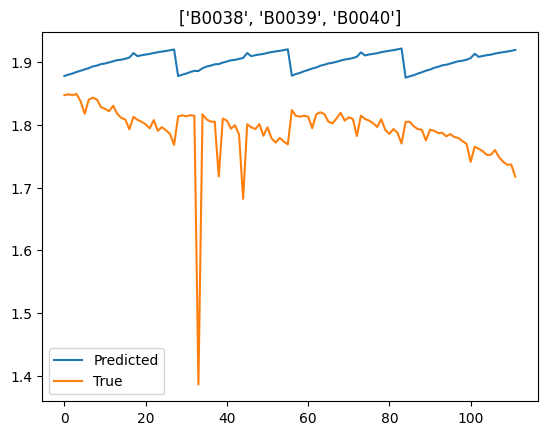

Evaluation Metrics for ['B0038', 'B0039', 'B0040']:
Mean Absolute Error (MAE): 0.10971900426855823
Mean Squared Error (MSE): 0.01474371374782021
Root Mean Squared Error (RMSE): 0.1214236951662245
       pred      true
0  1.877682  1.847011
1  1.879792  1.848565
2  1.881593  1.847111
3  1.884062  1.848984
4  1.886009  1.837012


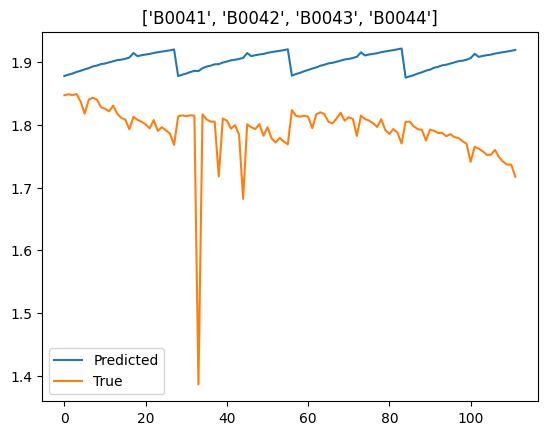

Evaluation Metrics for ['B0041', 'B0042', 'B0043', 'B0044']:
Mean Absolute Error (MAE): 0.10971900426855823
Mean Squared Error (MSE): 0.01474371374782021
Root Mean Squared Error (RMSE): 0.1214236951662245
       pred      true
0  1.877682  1.847011
1  1.879792  1.848565
2  1.881593  1.847111
3  1.884062  1.848984
4  1.886009  1.837012


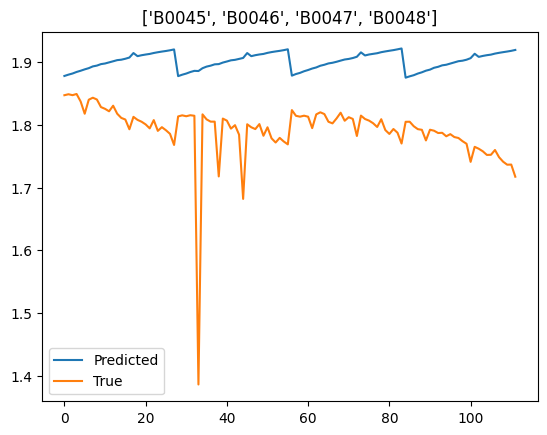

Evaluation Metrics for ['B0045', 'B0046', 'B0047', 'B0048']:
Mean Absolute Error (MAE): 0.10971900426855823
Mean Squared Error (MSE): 0.01474371374782021
Root Mean Squared Error (RMSE): 0.1214236951662245
       pred      true
0  1.877682  1.847011
1  1.879792  1.848565
2  1.881593  1.847111
3  1.884062  1.848984
4  1.886009  1.837012


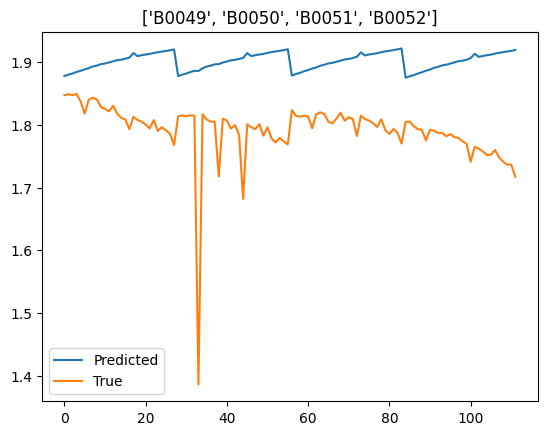

Evaluation Metrics for ['B0049', 'B0050', 'B0051', 'B0052']:
Mean Absolute Error (MAE): 0.10971900426855823
Mean Squared Error (MSE): 0.01474371374782021
Root Mean Squared Error (RMSE): 0.1214236951662245
       pred      true
0  1.877682  1.847011
1  1.879792  1.848565
2  1.881593  1.847111
3  1.884062  1.848984
4  1.886009  1.837012


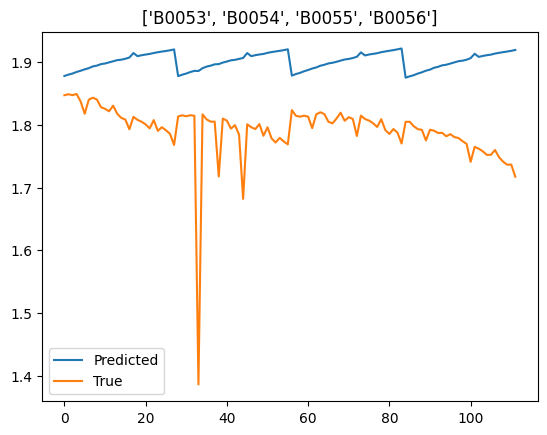

Evaluation Metrics for ['B0053', 'B0054', 'B0055', 'B0056']:
Mean Absolute Error (MAE): 0.10971900426855823
Mean Squared Error (MSE): 0.01474371374782021
Root Mean Squared Error (RMSE): 0.1214236951662245


In [ ]:
y_pred = loaded_model.predict(test_x, batch_size=BATCH_SIZE)
y_pred_last_timestep = y_pred.flatten()
# from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create a DataFrame to compare predictions and true values
df_pred = pd.DataFrame(data={'pred': y_pred_last_timestep, 'true': test_y})

# Print and visualize the first few predictions
print(df_pred.head())

plt.figure()
plt.plot(df_pred['pred'], label='Predicted')
plt.plot(df_pred['true'], label='True')
plt.legend()
plt.show()

# Calculate evaluation metrics for the test data
mae = mean_absolute_error(df_pred['true'], df_pred['pred'])
mse = mean_squared_error(df_pred['true'], df_pred['pred'])
rmse = np.sqrt(mse)

print(f"Evaluation Metrics for Test Data:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# For loading and evaluating on new experiments (as per your previous code snippet)
for experiment in [experiment3, experiment4, experiment5, experiment6, experiment7, experiment8, experiment9]:
    # Load another experiment as test data
    new_experiment = experiment  # Replace with the new experiment name

    # Assuming new_y_pred is computed from loaded_model.predict(new_test_x_padded, batch_size=BATCH_SIZE)

    # Select the predictions for the last timestep (assuming single value prediction per sequence)
    new_y_pred_last_timestep = new_y_pred.flatten()

    # Create a DataFrame to compare predictions and true values
    new_df_pred = pd.DataFrame(data={'pred': new_y_pred_last_timestep, 'true': new_test_y})

    # Display the predictions
    print(new_df_pred.head())

    # Plot the predictions and true values
    plt.figure()
    plt.title(new_experiment)
    plt.plot(new_df_pred['pred'], label='Predicted')
    plt.plot(new_df_pred['true'], label='True')
    plt.legend()
    plt.show()

    # Calculate evaluation metrics for the new experiment data
    new_mae = mean_absolute_error(new_df_pred['true'], new_df_pred['pred'])
    new_mse = mean_squared_error(new_df_pred['true'], new_df_pred['pred'])
    new_rmse = np.sqrt(new_mse)

    print(f"Evaluation Metrics for {new_experiment}:")
    print(f"Mean Absolute Error (MAE): {new_mae}")
    print(f"Mean Squared Error (MSE): {new_mse}")
    print(f"Root Mean Squared Error (RMSE): {new_rmse}")

Training Loss: 0.013959132134914398
13/13 [==============================] - 0s 6ms/step
Evaluation Metrics for Training Data:
Mean Absolute Error (MAE): 0.09816195652223762
Mean Squared Error (MSE): 0.013959132030662255
Root Mean Squared Error (RMSE): 0.11814877075391964
R-squared (R2) Score: 0.6747728737266616


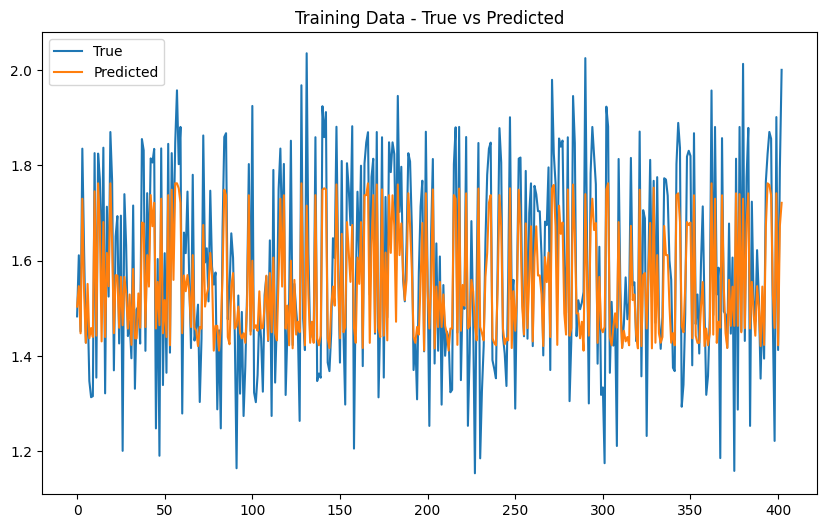

Validation Loss: 0.01643969677388668
4/4 [==============================] - 0s 11ms/step
Evaluation Metrics for Validation Data:
Mean Absolute Error (MAE): 0.10856643239314154
Mean Squared Error (MSE): 0.01643969287910897
Root Mean Squared Error (RMSE): 0.1282173657470351
R-squared (R2) Score: 0.6345665400199372


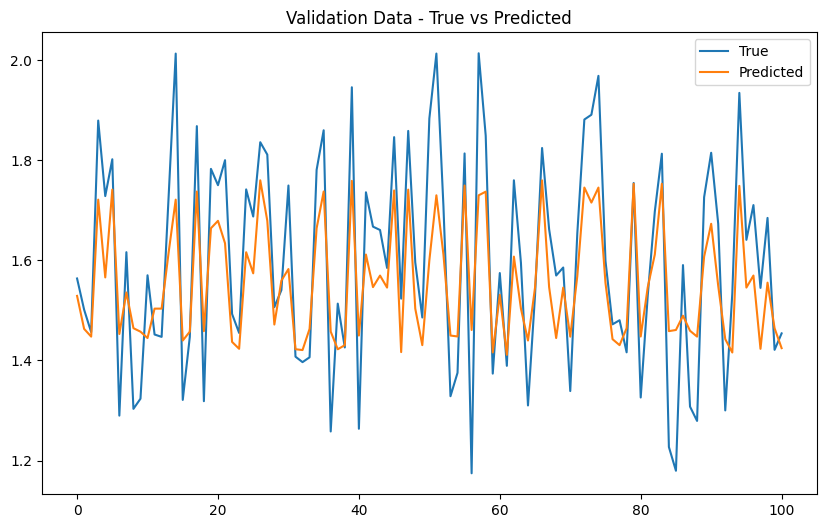

Test Loss for ['B0025', 'B0026', 'B0027', 'B0028']: 0.013844035565853119
4/4 [==============================] - 0s 5ms/step
Evaluation Metrics for Experiment ['B0025', 'B0026', 'B0027', 'B0028']:
Mean Absolute Error (MAE): 0.10750666079716738
Mean Squared Error (MSE): 0.013844038612132247
Root Mean Squared Error (RMSE): 0.11766069272332305
R-squared (R2) Score: -5.061808139924328


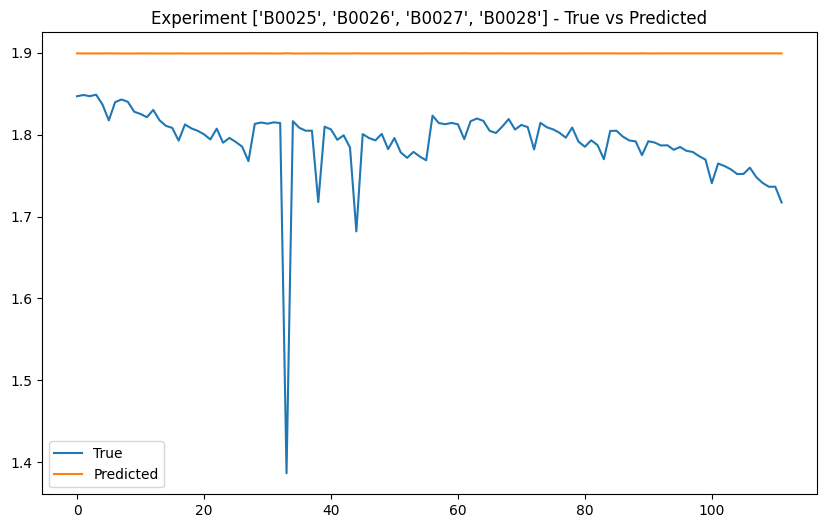

Test Loss for ['B0029', 'B0030', 'B0031', 'B0032']: 0.1566997766494751
5/5 [==============================] - 0s 4ms/step
Evaluation Metrics for Experiment ['B0029', 'B0030', 'B0031', 'B0032']:
Mean Absolute Error (MAE): 0.3895451388751493
Mean Squared Error (MSE): 0.1566997898456528
Root Mean Squared Error (RMSE): 0.3958532428131072
R-squared (R2) Score: -31.262792730021232


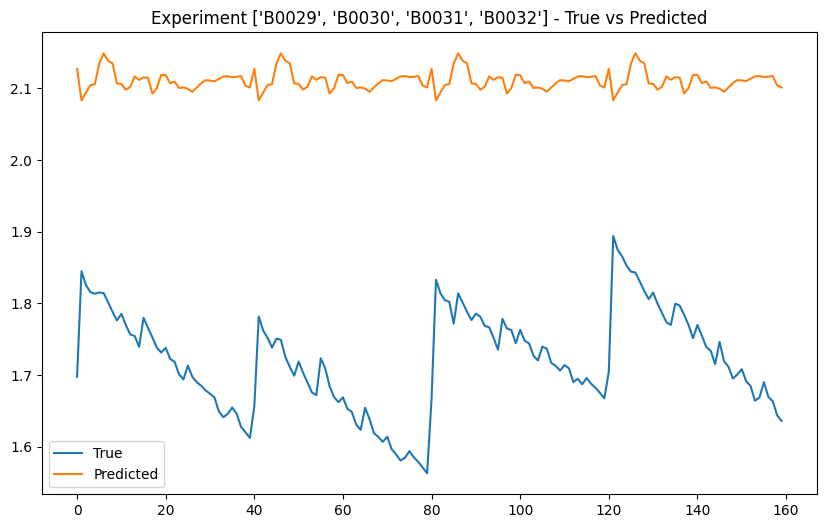

Test Loss for ['B0033', 'B0034', 'B0036']: 0.09572625905275345
19/19 [==============================] - 0s 4ms/step
Evaluation Metrics for Experiment ['B0033', 'B0034', 'B0036']:
Mean Absolute Error (MAE): 0.22802885242503254
Mean Squared Error (MSE): 0.09572626251899326
Root Mean Squared Error (RMSE): 0.3093966103870455
R-squared (R2) Score: -0.7829695662187663


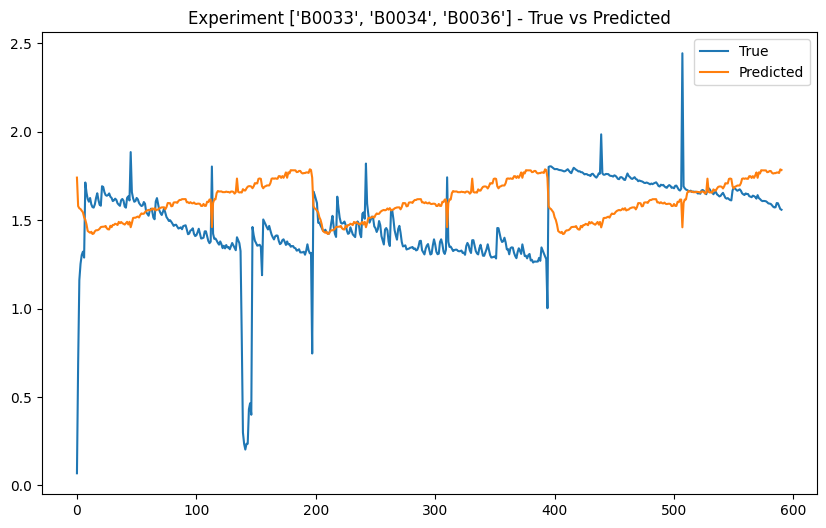

Test Loss for ['B0038', 'B0039', 'B0040']: 0.5789958238601685
5/5 [==============================] - 0s 5ms/step
Evaluation Metrics for Experiment ['B0038', 'B0039', 'B0040']:
Mean Absolute Error (MAE): 0.5009075048844005
Mean Squared Error (MSE): 0.5789958075821842
Root Mean Squared Error (RMSE): 0.7609177403518623
R-squared (R2) Score: -1.580736859157716


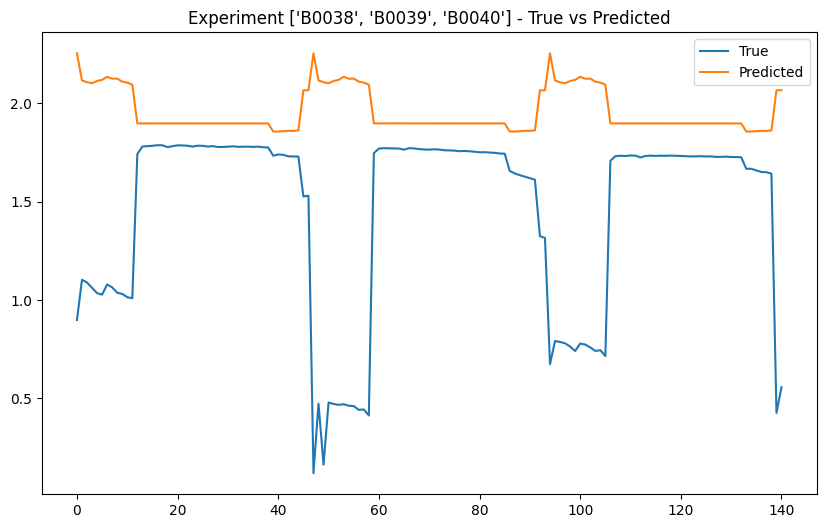

Battery B0042 not found in Cycles DataFrame
Battery B0043 not found in Cycles DataFrame
Battery B0044 not found in Cycles DataFrame
Test Loss for ['B0041', 'B0042', 'B0043', 'B0044']: 3.293957471847534
3/3 [==============================] - 0s 5ms/step
Evaluation Metrics for Experiment ['B0041', 'B0042', 'B0043', 'B0044']:
Mean Absolute Error (MAE): 1.7147990932234807
Mean Squared Error (MSE): 3.2939573102644344
Root Mean Squared Error (RMSE): 1.8149262547730236
R-squared (R2) Score: -15.87577047082689


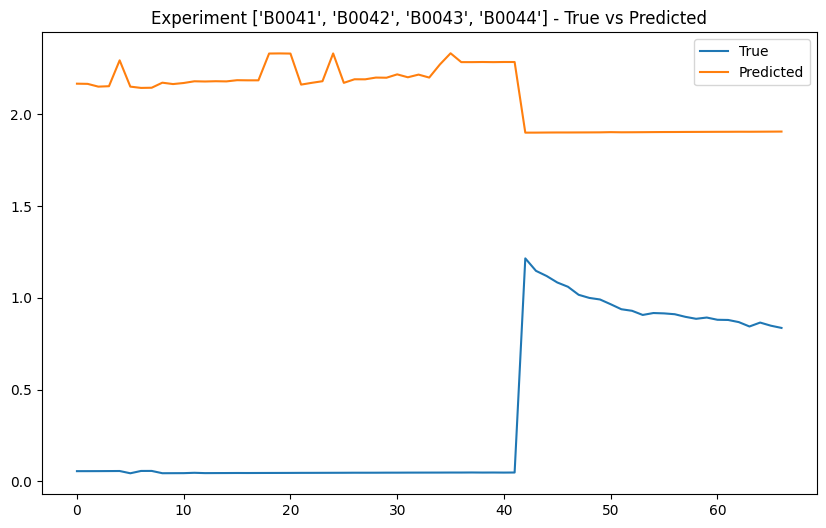

In [14]:
from sklearn.metrics import r2_score

def evaluate_experiment(model, X, y, experiment_name):
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)

    print(f"Evaluation Metrics for {experiment_name}:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R2) Score: {r2}")

    plt.figure(figsize=(10, 6))
    plt.plot(y, label='True')
    plt.plot(y_pred, label='Predicted')
    plt.title(f"{experiment_name} - True vs Predicted")
    plt.legend()
    plt.show()

# Evaluate on training data
train_loss = model.evaluate(train_x, train_y, verbose=0)
print(f"Training Loss: {train_loss}")
evaluate_experiment(model, train_x, train_y, "Training Data")

# Evaluate on validation data
val_loss = model.evaluate(test_x, test_y, verbose=0)
print(f"Validation Loss: {val_loss}")
evaluate_experiment(model, test_x, test_y, "Validation Data")

# Evaluate on new experiments
experiments = [experiment2, experiment3, experiment4, experiment5, experiment6]

for experiment in experiments:
    new_test_x, new_test_y = get_exp_based_df(experiment)

    # Normalize and pad the new test data
    max_len = train_x.shape[-1]
    new_test_x_padded = np.zeros((new_test_x.shape[0], new_test_x.shape[1], max_len))
    for i in range(new_test_x.shape[0]):
        for j in range(new_test_x.shape[1]):
            new_test_x_padded[i, j, :new_test_x.shape[2]] = new_test_x[i, j, :max_len]

    new_test_x = scaler.transform(new_test_x_padded.reshape(-1, new_test_x_padded.shape[-1])).reshape(new_test_x_padded.shape)

    # Evaluate the experiment
    test_loss = model.evaluate(new_test_x, new_test_y, verbose=0)
    print(f"Test Loss for {experiment}: {test_loss}")
    evaluate_experiment(model, new_test_x, new_test_y, f"Experiment {experiment}")